# Library

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from random import randrange

# time series Eda

In [2]:
df=pd.read_csv("metro.csv")

In [3]:
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [4]:
df.shape

(48204, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
df.index

RangeIndex(start=0, stop=48204, step=1)

In [7]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [8]:
df.describe(include = 'object')

,holiday,weather_main,weather_description,date_time
count,48204,48204,48204,48204
unique,12,11,38,40575
top,None,Clouds,sky is clear,2013-05-19 10:00:00
freq,48143,15164,11665,6


It turns out that there is a part of not unique dates in the "date_time" column. Let's remove the duplicates for this column and convert the data from the date_time column to the date/time format. Let's also translate the attribute "holiday" from categorical to numerical.

In [9]:
df = df.drop_duplicates(subset = 'date_time')
df['date_time'] = pd.to_datetime(df['date_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40575 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              40575 non-null  object        
 1   temp                 40575 non-null  float64       
 2   rain_1h              40575 non-null  float64       
 3   snow_1h              40575 non-null  float64       
 4   clouds_all           40575 non-null  int64         
 5   weather_main         40575 non-null  object        
 6   weather_description  40575 non-null  object        
 7   date_time            40575 non-null  datetime64[ns]
 8   traffic_volume       40575 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.1+ MB


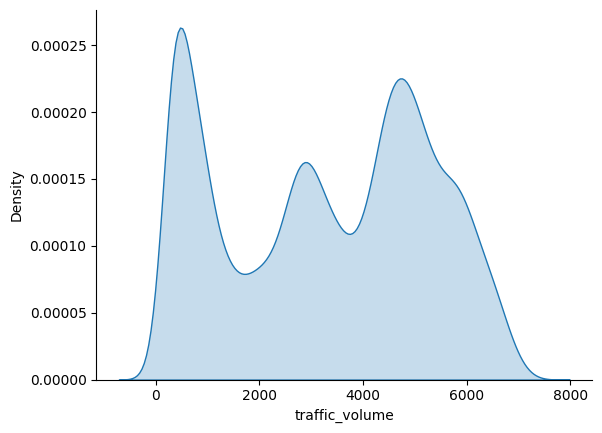

In [10]:
# Check Traffic volume distribution
sns.kdeplot(x= df.traffic_volume, shade= True)
sns.despine()

In [11]:
# convert the date time column to datetime format
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [12]:
# create new column for day name
df['weekday']= df['date_time'].dt.day_name()

In [13]:
# Show statistics of traffic volume for each day
df.groupby('weekday')['traffic_volume'].agg(['mean','count','min','max','sum']).sort_values(by= 'sum')

,mean,count,min,max,sum
weekday,,,,,
Sunday,2426.249484,5812,3,6645,14101362
Saturday,2822.564661,5784,0,6470,16325714
Monday,3313.560614,5799,123,7117,19215338
Tuesday,3534.717166,5703,125,7217,20158492
Wednesday,3608.276064,5803,1,7192,20938826
Thursday,3653.914611,5797,1,7280,21181743
Friday,3674.777608,5877,10,7241,21596668


In [14]:
# Sort dataframe by date_time to begin time series processing
df= df.sort_values(by= 'date_time')

In [15]:
# Set date_time column as index of data frame
df.set_index('date_time', inplace= True)

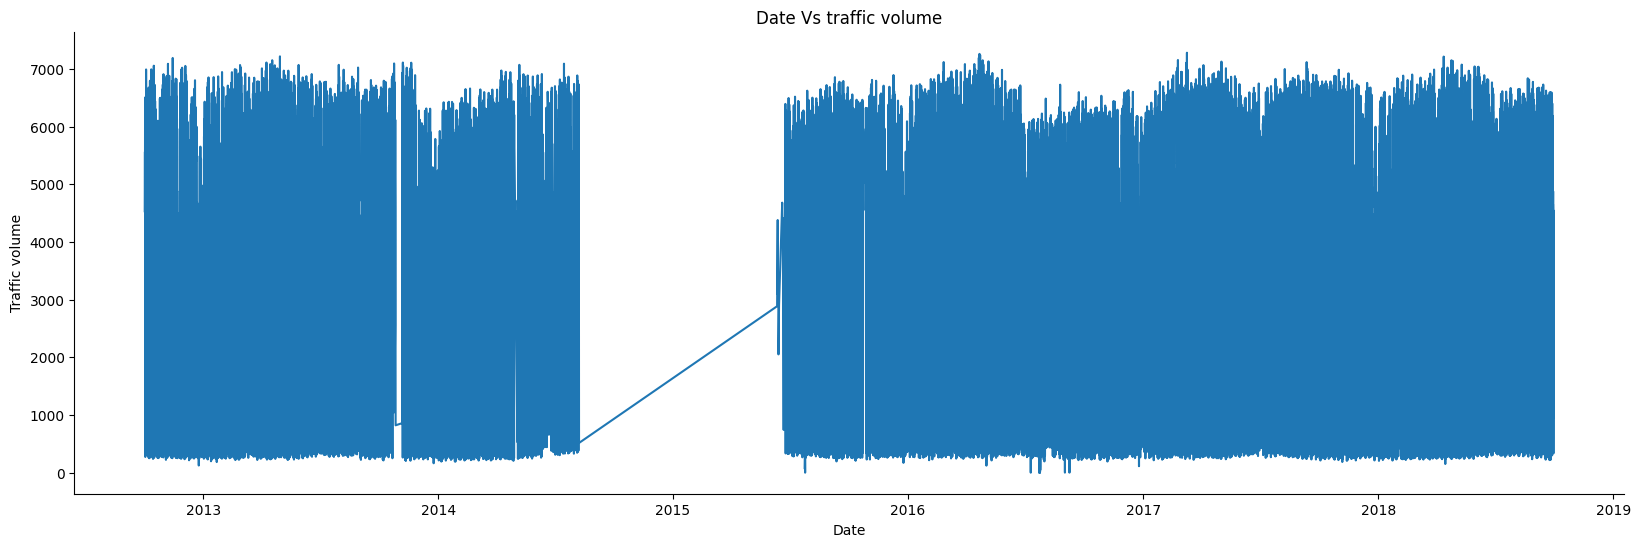

In [16]:
# Plot Date Vs Traffic volume
plt.figure(figsize=[20,6])
plt.plot(df.index, df['traffic_volume'])
plt.xlabel('Date')
plt.ylabel('Traffic volume')
plt.title('Date Vs traffic volume')
sns.despine()

It can be seen from the graph that there is no data for a significant period of time: for the second half of 2014 and the first half of 2015. We will have to use data from later periods, where there are no such gaps in the data, to build models. It seems to me that it makes no sense to artificially restore such a large gap. Let's take the data from January 1, 2016 to September 30, 2018 - the total will be 2 years and 9 months. Data omissions after this date are not so large, we will restore them as suggested in the task using the ffill interpolation method for subsequent values.

Data frequency is one hour, so in order to check what is missing, I first create an hourly daterange and then concatenate it with the dataset.

<Figure size 1500x600 with 0 Axes>

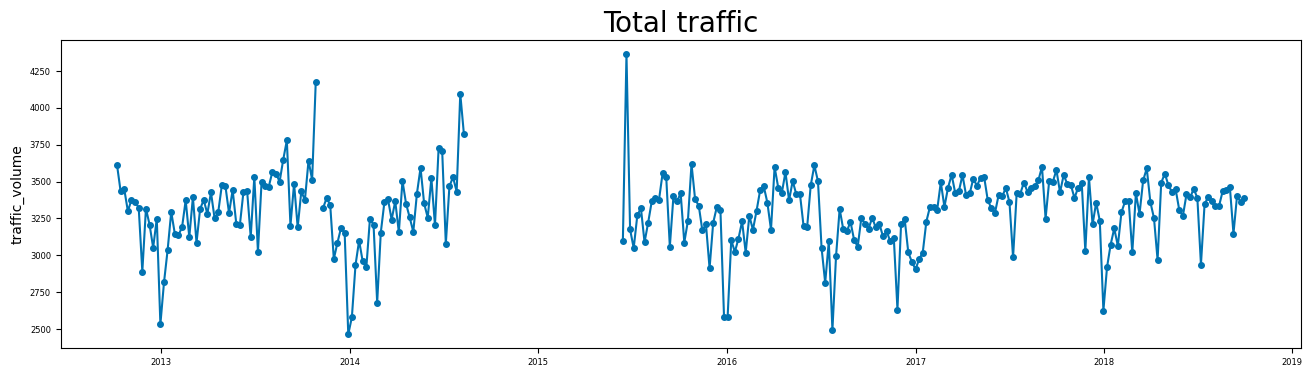

In [17]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = df['traffic_volume'].resample('W').mean() #weekly

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

<Figure size 1500x600 with 0 Axes>

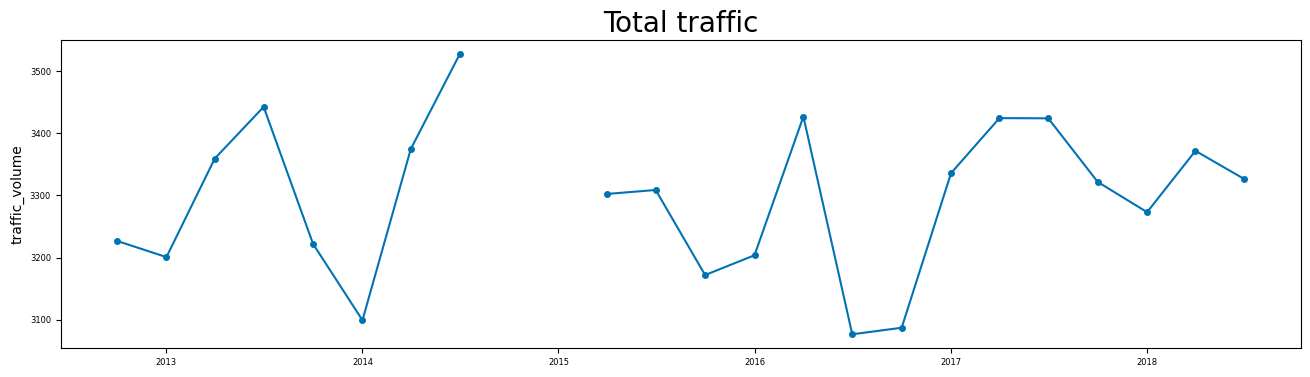

In [18]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = df['traffic_volume'].resample('Qs').mean() # quaterly

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

# Taking Our dataset

In [19]:
portion_df = df.traffic_volume['2018-09-01 00:00:00':]
# portion_df = portion_df.reset_index()
# portion_df.columns = ['date_time', 'traffic_volume']

In [20]:
portion = df.traffic_volume['2017-01-01 00:00:00':]
daily_df=np.ceil(portion.resample('D').median())

In [21]:
daily_df

date_time
2017-01-01    1915.0
2017-01-02    1903.0
2017-01-03    3994.0
2017-01-04    4257.0
2017-01-05    4316.0
               ...  
2018-09-26    4574.0
2018-09-27    4499.0
2018-09-28    4683.0
2018-09-29    3532.0
2018-09-30    2470.0
Freq: D, Name: traffic_volume, Length: 638, dtype: float64

In [22]:
portion_df.tail()

date_time
2018-09-30 19:00:00    3543
2018-09-30 20:00:00    2781
2018-09-30 21:00:00    2159
2018-09-30 22:00:00    1450
2018-09-30 23:00:00     954
Name: traffic_volume, dtype: int64

In [23]:
portion_df.shape

(720,)

<Figure size 1500x600 with 0 Axes>

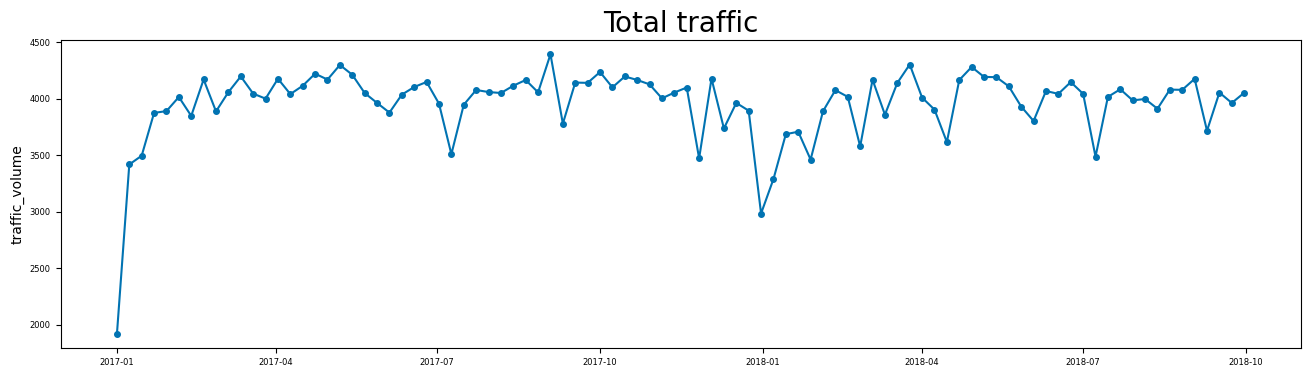

In [24]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = daily_df.resample('W').mean() #Daily

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

<Figure size 1500x600 with 0 Axes>

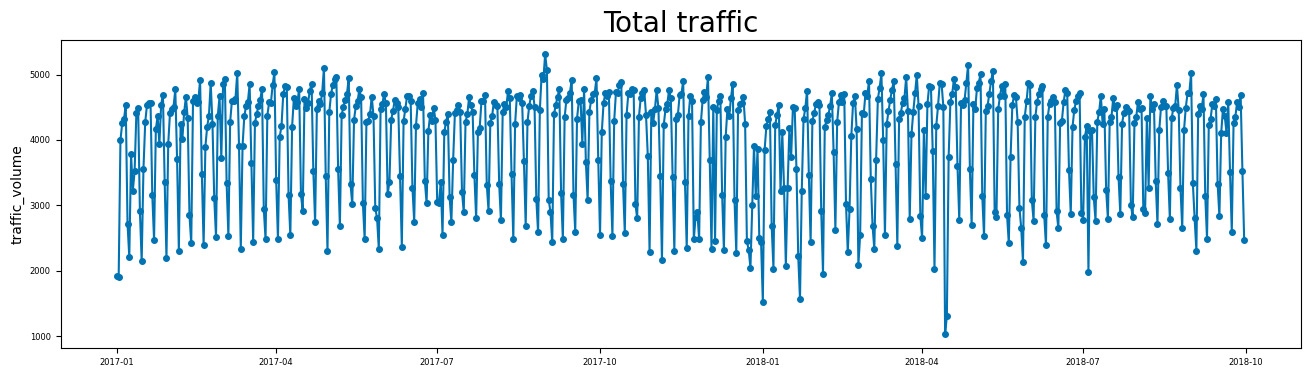

In [25]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = daily_df.resample('D').mean() #Daily

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

In [26]:
 
ssd=df.traffic_volume['2018-09-15 00:00:00':]

<Figure size 2500x600 with 0 Axes>

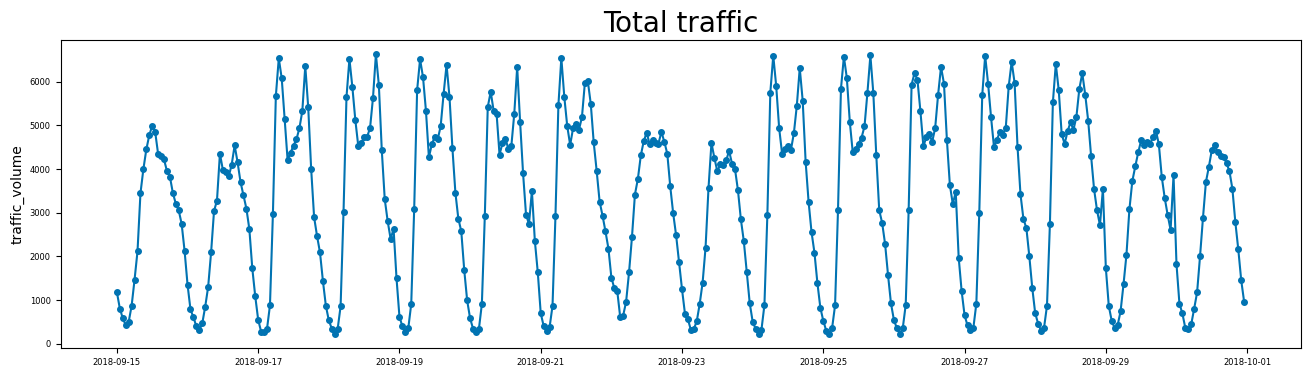

In [27]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(25, 6))
y = ssd.resample('H').max() #Daily

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

- from above graph we confirm that traffic volume repeat weekly
- visible daytime and evening peaks there is a drop in traffic on the weekend

<Axes: xlabel='date_time'>

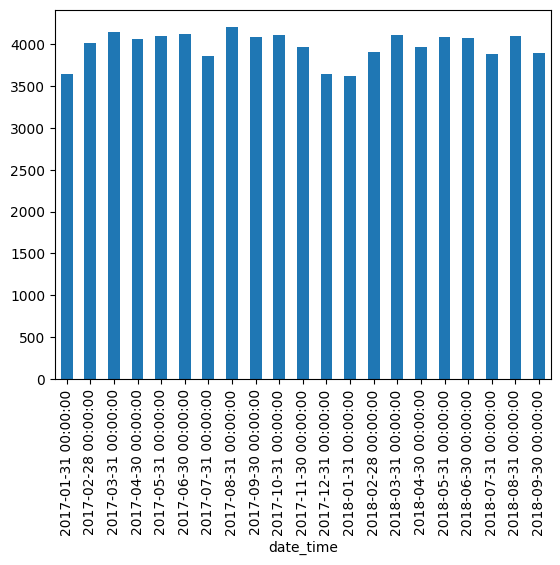

In [28]:
##plotting
daily_df.resample('M').mean().plot(kind='bar')

<Axes: xlabel='date_time'>

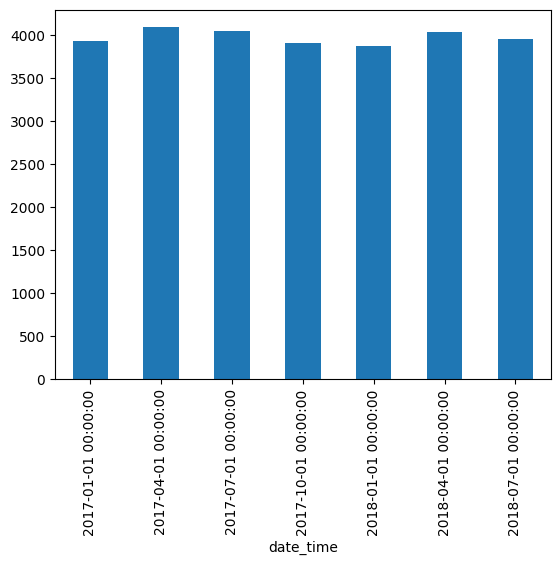

In [29]:
##plotting
daily_df.resample('Qs').mean().plot(kind='bar')

# time Series analysis

- Seasonality
- stationary
- trend
- cylcic

## Decompostion check

<Figure size 1500x600 with 0 Axes>

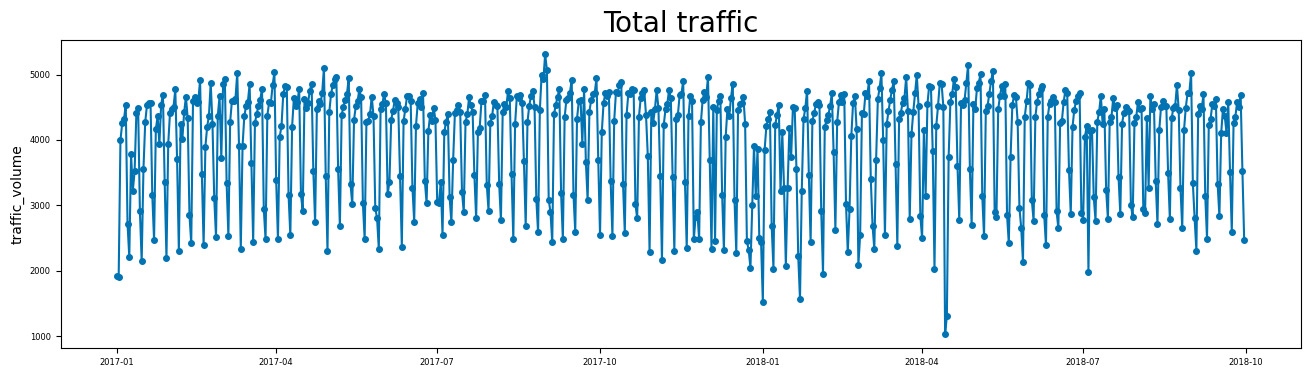

In [30]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = daily_df.resample('D').mean()

plot_series(y)
plt.title('Total traffic', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
plt.show()

In [31]:
portion_df

date_time
2018-09-01 00:00:00    1335
2018-09-01 01:00:00     785
2018-09-01 02:00:00     569
2018-09-01 03:00:00     425
2018-09-01 04:00:00     419
                       ... 
2018-09-30 19:00:00    3543
2018-09-30 20:00:00    2781
2018-09-30 21:00:00    2159
2018-09-30 22:00:00    1450
2018-09-30 23:00:00     954
Name: traffic_volume, Length: 720, dtype: int64

<Figure size 640x480 with 0 Axes>

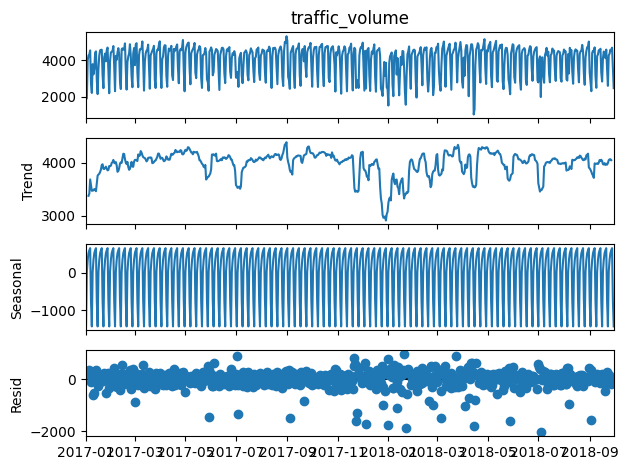

<Figure size 640x480 with 0 Axes>

In [32]:
result_air=seasonal_decompose(daily_df, model='additive')
result_air.plot()
plt.figure()

<Axes: xlabel='date_time'>

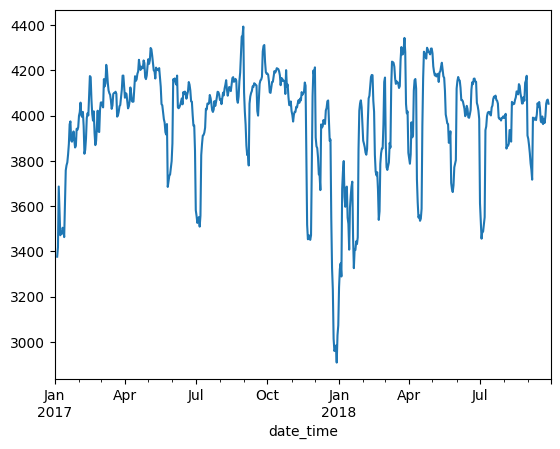

In [33]:
result_air.trend.plot()

In [34]:
result_air=seasonal_decompose(daily_df, model='additive',period=7)

<Figure size 640x480 with 0 Axes>

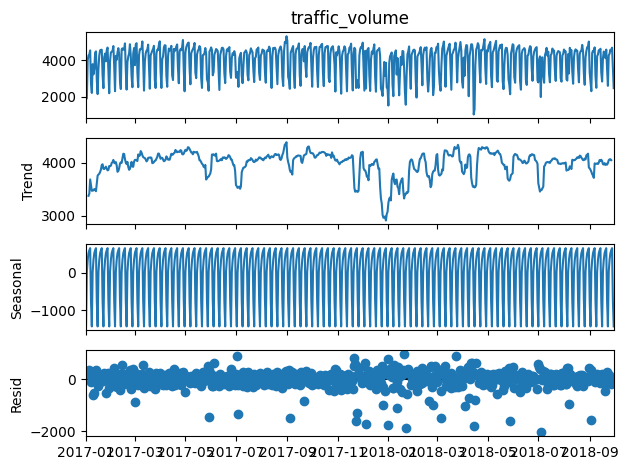

<Figure size 640x480 with 0 Axes>

In [35]:
result_air.plot()
plt.figure()

<Axes: xlabel='date_time'>

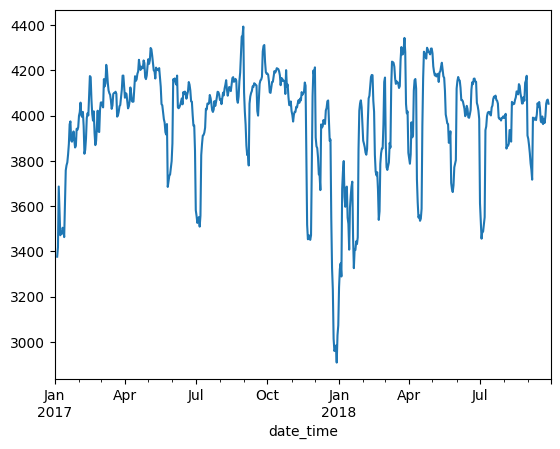

In [36]:
result_air.trend.plot()

<Figure size 640x480 with 0 Axes>

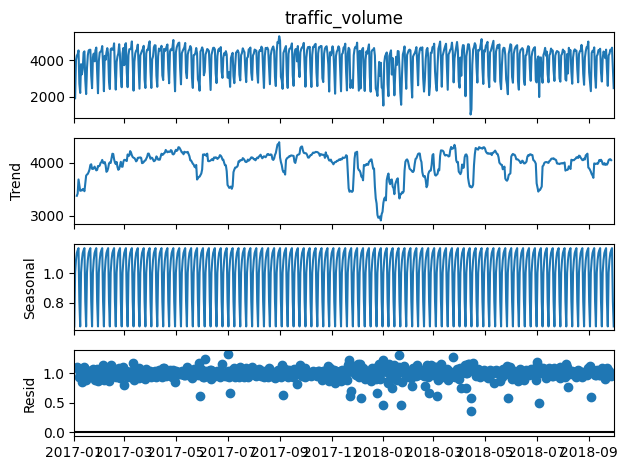

<Figure size 640x480 with 0 Axes>

In [37]:
# decomposed = seasonal_decompose(portion_df, model='multiplicative')
# fig = decomposed.plot()
# fig.set_size_inches(14, 10)  # Adjust the figure size as needed
# plt.show()
result_air=seasonal_decompose(daily_df, model='multiplicative',period=7)
result_air.plot()
plt.figure()

almost multiplicative time series

how we make series multiplicative

# checking Stationary
- constant mean
- constant sd
-constant autocorrelation
- no seasionality/trend

In [38]:
daily_df.tail()

date_time
2018-09-26    4574.0
2018-09-27    4499.0
2018-09-28    4683.0
2018-09-29    3532.0
2018-09-30    2470.0
Freq: D, Name: traffic_volume, dtype: float64

In [39]:
daily_df.shape[0]

638

In [40]:
# Split data into Train & Test in order matter
split_date = '2018-05-3'
ts_train = daily_df[daily_df.index <= split_date]
ts_test = daily_df[daily_df.index > split_date]

In [41]:
X=daily_df.values
p_kpss = kpss(ts_train,regression = 'c')
print('p-value KPSS test: %f' % p_kpss[1])


p-value KPSS test: 0.100000


C:\Users\Sagar Kumar\AppData\Local\Temp\ipykernel_13908\360195809.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss = kpss(ts_train,regression = 'c')


In [42]:
X=daily_df

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.575214
p-value: 0.006253
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


Both tests are based on different hypotheses:

The Dickey-Fuler test takes as the null hypothesis that the series is stationary, i.e. the p-value for this test confirms the null hypothesis that the series is stationary.
The KPSS test, on the contrary, takes as a null hypothesis the assertion that the series is non-stationary. In our example, the result of the test is not so much unambiguous, since the result is a value of 4%, which is less than the 5% significance threshold, but greater than the 1% significance threshold. Different interpretations are possible, for this training example we will take a significance threshold of 1% and consider that the series is still stationary.

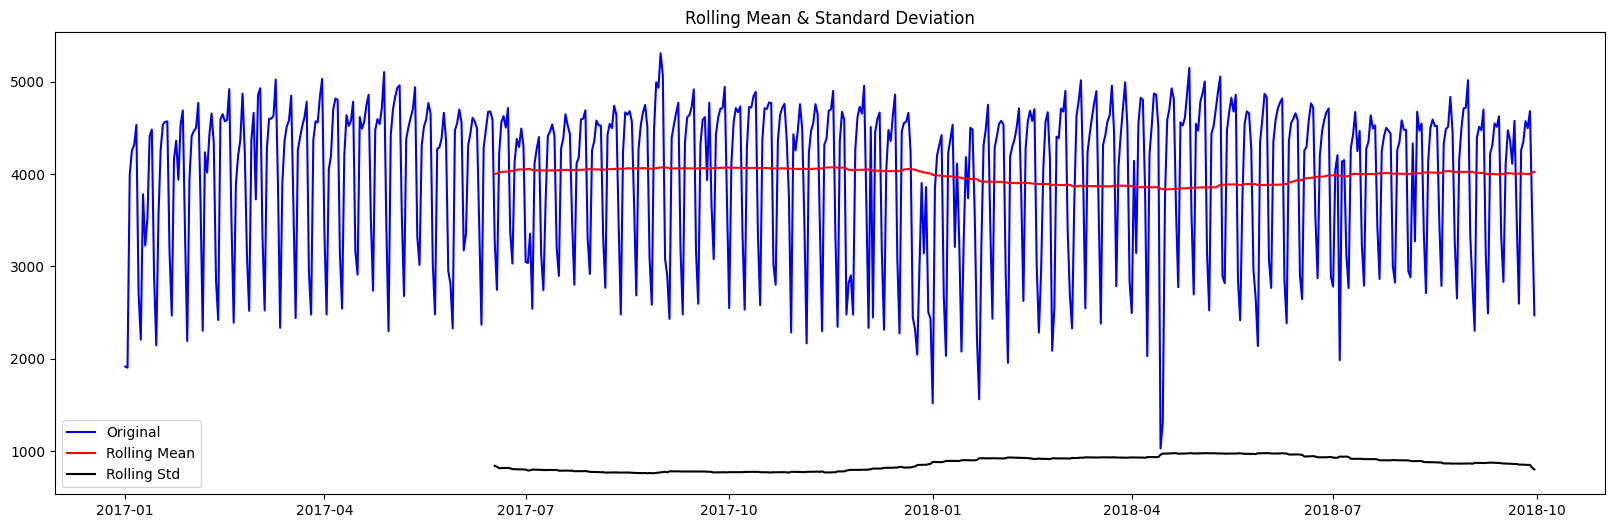

Results of Dickey-Fuller Test:
Test Statistic                  -3.575214
p-value                          0.006253
#Lags Used                      20.000000
Number of Observations Used    617.000000
Critical Value (1%)             -3.440993
Critical Value (5%)             -2.866236
Critical Value (10%)            -2.569271
dtype: float64


In [43]:
def test_stationarity(timeseries):
    
    # Determie rolling statistics
    rolmean = timeseries.rolling(168).mean()
    rolstd = timeseries.rolling(168).std()

    # Plot rolling statistics:
    plt.figure(figsize=[20,6])
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print (dfoutput)
test_stationarity(daily_df)

# large gap in mean
# if it is not stationay then apply diffencing


# In my case we need to apply differncing in according to dicker fuller test to convert in stationary

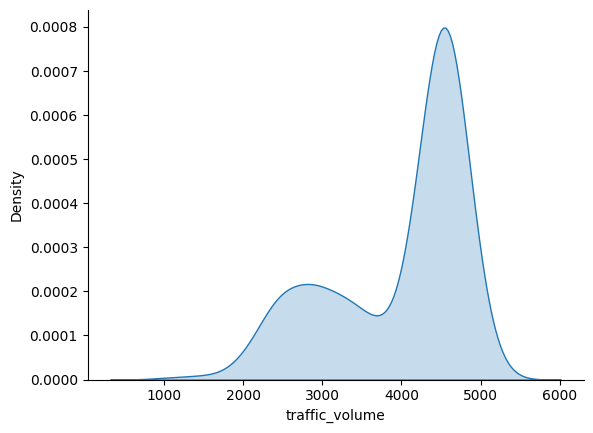

In [51]:
# Check Traffic volume distribution
sns.kdeplot(x= daily_df, shade= True)
sns.despine()

In [50]:
daily_df


date_time
2017-01-01    1915.0
2017-01-02    1903.0
2017-01-03    3994.0
2017-01-04    4257.0
2017-01-05    4316.0
               ...  
2018-09-26    4574.0
2018-09-27    4499.0
2018-09-28    4683.0
2018-09-29    3532.0
2018-09-30    2470.0
Freq: D, Name: traffic_volume, Length: 638, dtype: float64

# acf pcf plot

In [57]:
ts_train.shape

(488,)

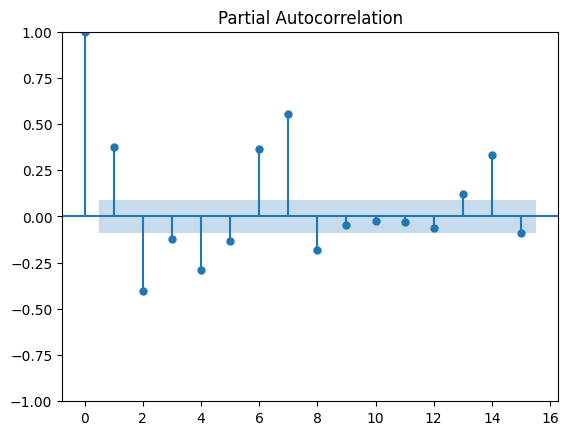

In [58]:
plot_pacf(ts_train, alpha=0.05,lags=15)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-0.20,linestyle='--',color='red')
# plt.axhline(y=0.20,linestyle='--',color='red')
plt.show()

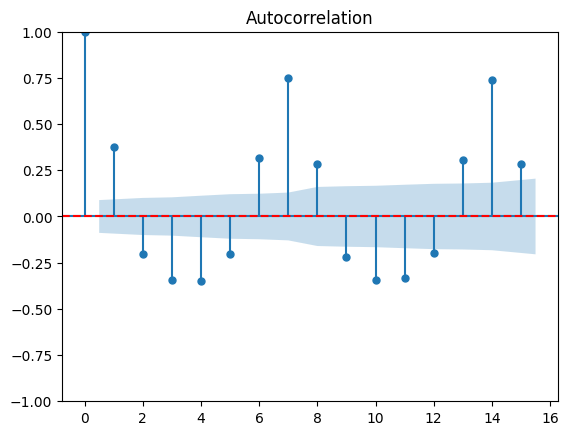

In [60]:
plot_acf(ts_train,alpha=0.05,lags=15)
plt.axhline(y=0,linestyle='--',color='red')
# plt.axhline(y=-0.20,linestyle='--',color='red')
# plt.axhline(y=0.20,linestyle='--',color='red')
plt.show()

In [64]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
lag = 35
lag_pacf = pacf(ts_train, nlags=lag, method='ols')
lag_acf = acf(ts_train, nlags=lag)

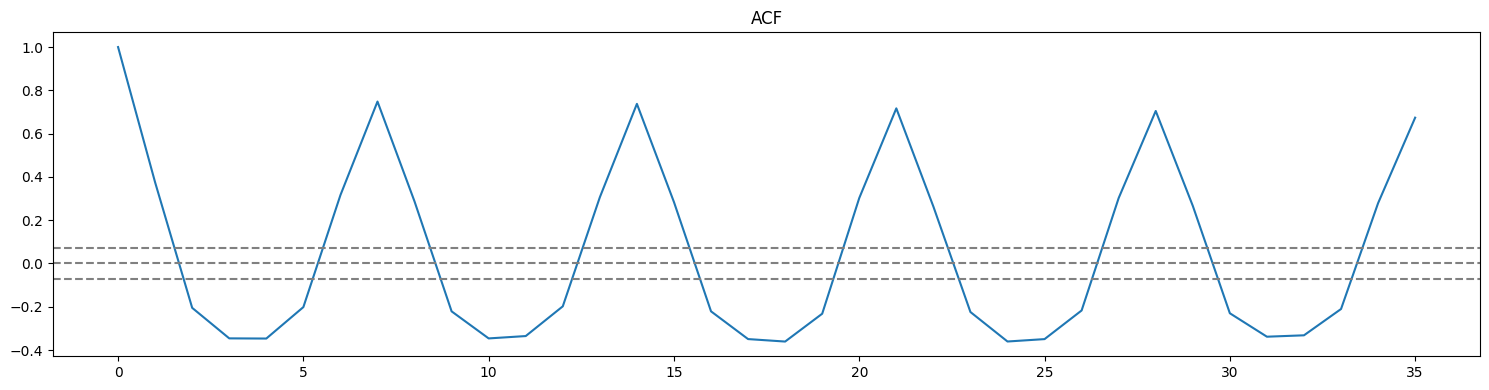

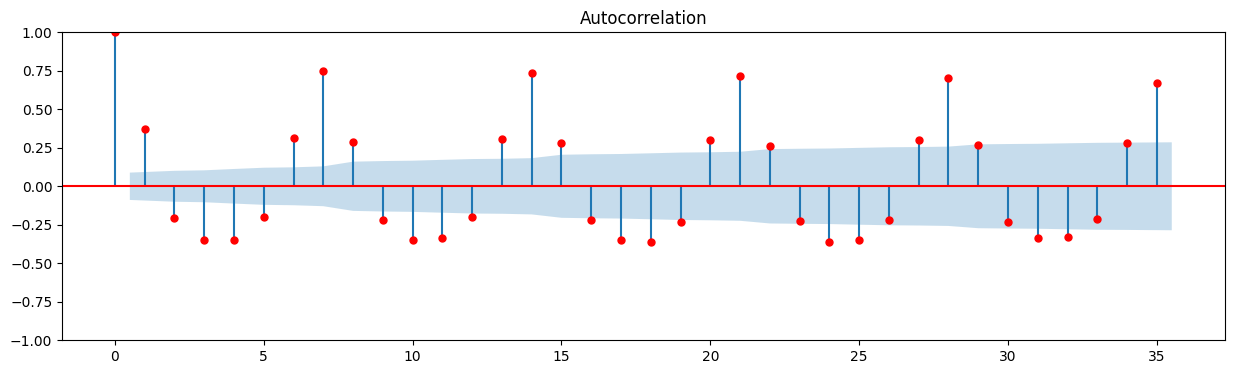

In [65]:
#Plot ACF auto corrletion function 
plt.figure(figsize=[15,4])
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(portion_df)), linestyle= '--', color= 'gray')
plt.axhline(y=1.96/np.sqrt(len(portion_df)), linestyle= '--', color= 'gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plot_acf(ts_train, ax= plt.gca(), lags= lag, color= 'red')
plt.show()

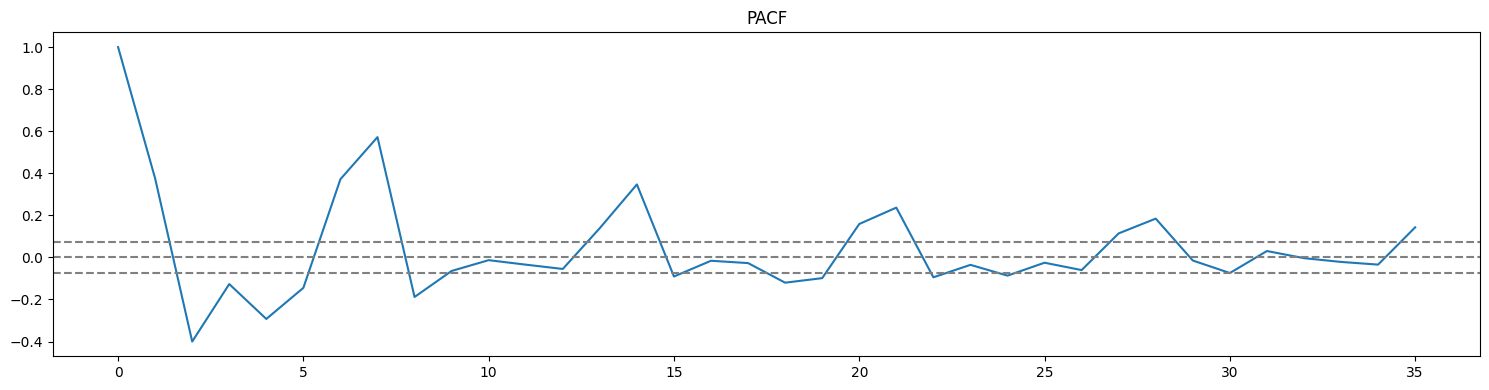

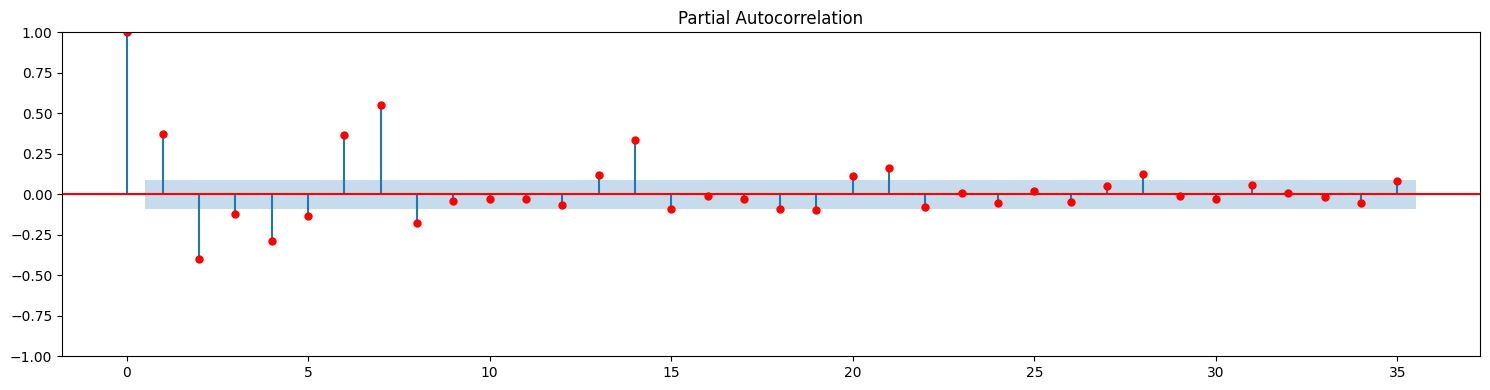

In [66]:
#Plot PACF partial auto corrletion function
plt.figure(figsize=(15,4))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,4))
plot_pacf(ts_train, ax=plt.gca(), lags=lag, color= 'red')
plt.tight_layout()
plt.show()

# geometric decay in acf and significant spike in pacf
# Determine p, q and d values
both acf and pacf have significiant spike and decay so it is arma process
- p upto 15
- q upto 7


# day 3

p=past values
q=past error
d=difference

# arma

In [73]:
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

p_values = range(6,9 )
q_values = range(6, 10)

fitted_model_dict = {}

for p, q in product(p_values, q_values):
    # Create ARMA(p,q) model
    arma_model = ARIMA(daily_df, order=(p, 0, q))
    arma_model_fit = arma_model.fit()
    
    # Store AIC and BIC scores
    aic_score = arma_model_fit.aic
    bic_score = arma_model_fit.bic
    
    fitted_model_dict[(p, q)] = {'AIC': aic_score, 'BIC': bic_score}

C:\Users\Sagar Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sagar Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sagar Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sagar Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

In [74]:
for (p, q), scores in fitted_model_dict.items():
    print(f'ARMA({p},{q}) - AIC: {scores["AIC"]}, BIC: {scores["BIC"]}')

ARMA(6,6) - AIC: 9660.900796275931, BIC: 9723.317532242758
ARMA(6,7) - AIC: 9661.358449237985, BIC: 9728.233523488158
ARMA(6,8) - AIC: 9651.560854200547, BIC: 9722.894266734063
ARMA(6,9) - AIC: 9651.905734158907, BIC: 9727.697484975768
ARMA(7,6) - AIC: 9607.502535394655, BIC: 9674.377609644827
ARMA(7,7) - AIC: 9582.743765759595, BIC: 9654.077178293112
ARMA(7,8) - AIC: 9566.654811025266, BIC: 9642.446561842127
ARMA(7,9) - AIC: 9592.007783988896, BIC: 9672.257873089102
ARMA(8,6) - AIC: 9671.974852676045, BIC: 9743.308265209562
ARMA(8,7) - AIC: 9586.122864563597, BIC: 9661.914615380458
ARMA(8,8) - AIC: 9573.81548060108, BIC: 9654.065569701286
ARMA(8,9) - AIC: 9559.166378808777, BIC: 9643.874806192329


# arma

In [83]:
# from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima

In [84]:
# %%time


# stepwise_fit=auto_arima(ts_train,start_p=0, start_q=0,d=1,
#                            max_p=15, max_q=7,information_criterion='bic',trace=True,suppress_warnings=True,stepwise=True,seasonal=False)
# stepwise_fit.summary()


In [85]:
model=ARIMA(ts_train,order=(8,0,9))
model=model.fit()
model.summary()

C:\Users\Sagar Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                  488
Model:                 ARIMA(8, 0, 9)   Log Likelihood               -3656.631
Date:                Fri, 19 Jul 2024   AIC                           7351.263
Time:                        13:25:40   BIC                           7430.879
Sample:                    01-01-2017   HQIC                          7382.536
                         - 05-03-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3973.7767    232.930     17.060      0.000    3517.242    4430.311
ar.L1          0.9238      0.417      2.218      0.027       0.107       1.740
ar.L2          0.0003      0.014      0.024      0.981      -0.028       0.028
ar.L3         -0.0049      0.014     -0.345      0.730      -0.033       0.023
ar.L4          0.0016      0.017      0.096      0.924      -0.032       0.035
ar.L5         -0.0065      0.013     -0.494      0.621      -0.032       0.019
ar.L6          0.0048      0.015      0.318      0.751      -0.025       0.035
ar.L7          0.9905      0.011     90.771      0.000       0.969       1.012
ar.L8         -0.9206      0.405     -2.271      0.023      -1.715      -0.126
ma.L1         -0.5695      0.426     -1.336      0.181      -1.405       0.266
ma.L2         -0.2377      0.147     -1.617      0.106      -0.526       0.050
ma.L3          0.0074      0.063      0.117      0.907      -0.117       0.132
ma.L4          0.0623      0.070      0.895      0.371      -0.074       0.199
ma.L5         -0.0021      0.088     -0.024      0.981      -0.174       0.170
ma.L6          0.0378      0.083      0.456      0.648      -0.125       0.200
ma.L7         -0.9421      0.083    -11.376      0.000      -1.104      -0.780
ma.L8          0.4980      0.319      1.561      0.119      -0.127       1.123
ma.L9          0.2236      0.088      2.548      0.011       0.052       0.396
sigma2      2.043e+05   1.09e+04     18.744      0.000    1.83e+05    2.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):              1741.65
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                            -2.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""